In [ ]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import ToTensor, Compose, Resize, Grayscale, ColorJitter, RandomAffine, Pad, Normalize, RandomAutocontrast, RandomEqualize
from google.colab.patches import cv2_imshow
from tqdm.notebook import tqdm, trange
import shutil
from copy import deepcopy
import torchvision.models as models

In [ ]:
!unzip imgs_r_r.zip -d imgs_r

# Создание датасета

In [ ]:
# Создание класса датасета

from contextlib import nullcontext
def to_letter(x):
    return chr(ord("A") + x)
class ImagenetteDataset(Dataset):
    def __init__(self, csv="examples.csv",path = None, train=True, transform=None):

        """
        labels_column отвечает из какой колонки будем получать лейблы классов для обучения/валидации, будем использовать `noisy_labels_0`

        Так как значения лейблов -- это строки, для того, чтобы превратить их в числа, можно воспользоваться LabelEncoder
        """

        self.transform = transform    
        # self.train_transform = transform
        self.train = train
        if path is None:
            self.path = ["imgs_r", "imgs_rotated"]
        if train:
            self.df = pd.read_csv(csv)
            self.df["label"] = self.df["label"].map(lambda x: ord(x.upper()) - ord("A"))
        else:
            self.df = pd.DataFrame()
            self.df["path"] = os.listdir(os.path.join(*self.path))
            
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        # load image
        # transform image
        # return dict with image and class label
        if index in self.df.index:        
            img = cv2.imread(os.path.join(*self.path, self.df.loc[index, "path"]))
            # RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # if self.train:
            if self.train:
                return {
                    "image": self.transform(RGB_img),
                    "label": self.df.loc[index, "label"]
                    }
            else:
                return {
                    "image": self.transform(RGB_img),
                    "paths": self.df.loc[index, "path"]
                    }


In [ ]:
image_size = 128

transform = Compose([
                    #  RandomEqualize(0.5),
                    ToTensor(),
                    Pad(30, fill = 1),
                    RandomAffine(degrees = 0,
                                 translate = (30/(75 + 60), 30/(75 + 60)),
                                #  shear = (30),
                                 fill = 1),
                     
                    Resize((image_size, image_size)),
                    Grayscale(3),
                    # Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2)),
                     
])


train_ds = ImagenetteDataset(train = True, transform = transform)
test_ds = ImagenetteDataset(train = False, transform = transform)

## Проверка

In [ ]:
import matplotlib.pyplot as plt

import torchvision.transforms.functional as Ftt

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs, tt = True):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        # if tt:
        img = Ftt.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

0
1
2
3
4


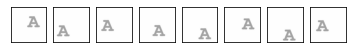

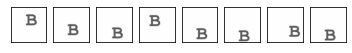

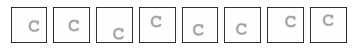

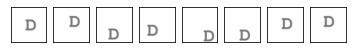

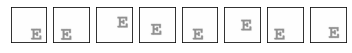

In [ ]:
for i in range(5):
    print(train_ds[i]["label"])
    show([train_ds[i]["image"] for j in range(8)])

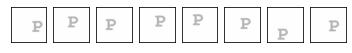

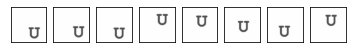

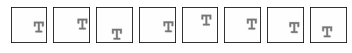

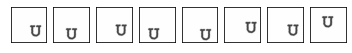

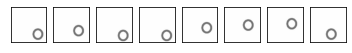

In [ ]:
for i in range(5):
    # print(train_ds[i]["label"])
    show([test_ds[i]["image"] for j in range(8)])

In [ ]:
train_ds[0]["image"][2, :,:].max()

tensor(0.9999)

In [ ]:
len(train_ds), len(test_ds)

(300, 13456)

 # Создание модели

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def activation_func(activation):
    """https://www.machinelearningmastery.ru/residual-network-implementing-resnet-a7da63c7b278/"""
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]


class VeryModel(nn.Module):
    def __init__(self, lr_scheduler=None, lr_scheduler_type=None, activation='leaky_relu'):
        super().__init__()
        self.lr_scheduler = lr_scheduler
        self.lr_scheduler_type = lr_scheduler_type
        if lr_scheduler_type not in [None, 'per_batch', 'per_epoch']:
            raise ValueError("lr_scheduler_type must be one of: None, 'per_batch', 'per_epoch'. "
                             f"Not: {lr_scheduler_type}")
        self.inner = models.resnet18(num_classes=26) 

    def forward(self, x):
        return self.inner(x)

    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        x = batch['image']
        y = batch['label']
        logits = self.inner(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)
        metrics["preds"] = list(logits.argmax(axis=1))
        metrics["true"] = list(y)
        return loss, metrics

    def post_train_batch(self):
        pass

    def post_val_batch(self):
        pass

    def post_train_stage(self):
        pass

    def post_val_stage(self, val_loss):
        pass

In [ ]:
class Trainer:
    def __init__(self, model: nn.Module,
                 optimizer,
                 train_dataset: Dataset,
                 val_dataset,
                 device: str = 'cpu',
                 tboard_log_dir: str = './tboard_logs/',
                 batch_size: int = 128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size
        self.tboard_log_dir = tboard_log_dir

        self.device = device
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        # self.log_writer = SummaryWriter(log_dir=tboard_log_dir)

        # сохраняем состояние оптимизатора и модели
        self.cache = self.cache_states()

    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer

        train_loader = DataLoader(self.train_dataset, shuffle=True, pin_memory=True, batch_size=self.batch_size)
        # val_loader = DataLoader(self.val_dataset, shuffle=False, pin_memory=True, batch_size=self.batch_size)
        best_loss = float('inf')
        ddd = True

        for epoch in trange(num_epochs):
            model.train()
            for batch in train_loader:
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                model.post_train_batch()
                # for k, v in details.items():
                #     self.log_writer.add_scalar(k, v, global_step=self.global_step)
                self.global_step += 1

            # with torch.no_grad():
            #     model.eval()
            #     val_losses = []
            #     count_steps = 0
            #     sum_acc = 0
            #     sum_loss = 0
            #     self.preds = []
            #     self.true = []
            #     for batch in tqdm(val_loader):
            #         batch = {k: v.to(self.device) for k, v in batch.items()}
            #         loss, details = model.compute_all(batch)
            #         val_losses.append(loss.item())
            #         sum_acc += details["acc"]
            #         sum_loss += loss.item()
            #         count_steps += 1
            #         self.preds.extend(details["preds"])
            #         self.true.extend(details["true"])


            #     val_loss = np.mean(val_losses)
            #     model.post_val_stage(val_loss)
            #     self.sum_acc = sum_acc / count_steps
            #     self.sum_loss = sum_loss / count_steps
            #     self.log_writer.add_scalar(tag = "val/accuracy",
            #                                scalar_value  = self.sum_acc,
            #                                global_step=epoch)
            #     self.log_writer.add_scalar(tag = "val/loss",
            #                                scalar_value  = sum_loss / count_steps,
            #                                global_step=epoch)
            #     print(f"data_added ({epoch})")
                

                # if val_loss < best_loss:
                #     self.save_checkpoint(os.path.join(self.tboard_log_dir, "best_checkpoint.pth"))
                #     best_loss = val_loss

    def find_lr(self, min_lr: float = 1e-8,
                max_lr: float = 1e-1,
                num_lrs: int = 20,
                smooth_beta: float = 0.8) -> dict:
        lrs = np.geomspace(start=min_lr, stop=max_lr, num=num_lrs)
        logs = {'lr': [], 'loss': [], 'avg_loss': []}
        avg_loss = None
        model, optimizer = self.model, self.optimizer
        train_loader = DataLoader(self.train_dataset, shuffle=True, batch_size=self.batch_size)

        train_loader_iter = iter(train_loader)

        model.train()
        for lr in tqdm(lrs, desc='finding LR', total=num_lrs):

            try:
                batch = next(train_loader_iter)
            except StopIteration:
                train_loader_iter = iter(train_loader)
                batch = next(train_loader_iter)
            # apply new lr
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr

            # train step
            batch = {k: v.to(self.device) for k, v in batch.items()}
            loss, details = model.compute_all(batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate smoothed loss
            if avg_loss is None:
                avg_loss = loss
            else:
                avg_loss = smooth_beta * avg_loss + (1 - smooth_beta) * loss

            # store values into logs
            logs['lr'].append(lr)
            logs['avg_loss'].append(avg_loss.item())
            logs['loss'].append(loss.item())

        logs.update({key: np.array(val) for key, val in logs.items()})
        self.rollback_states()

        return logs

    def cache_states(self):
        cache_dict = {'model_state': deepcopy(self.model.state_dict()),
                      'optimizer_state': deepcopy(self.optimizer.state_dict())}

        return cache_dict

    def rollback_states(self):
        self.model.load_state_dict(self.cache['model_state'])
        self.optimizer.load_state_dict(self.cache['optimizer_state'])

# Обучение модели и запись результатов

In [ ]:
from torch.optim import SGD
from torchvision import datasets, transforms as T
import gc


image_size = 224
num_epochs = 10000

torch.cuda.empty_cache()
gc.collect()
torch.manual_seed(42)

scheduler = None
lr_scheduler_type = None
model = VeryModel()
optimizer = SGD(model.parameters(), lr=0.01)

trainer = Trainer(model,
                optimizer,
                ImagenetteDataset(train=True, transform=transform),
                ImagenetteDataset(train=False, transform=transform),
                batch_size=128,
                device = "gpu",
                tboard_log_dir = f"best")
trainer.train(num_epochs = num_epochs)

  0%|          | 0/10000 [00:00<?, ?it/s]

   P   U   T   U   O   O   D   P   Q   F   D   W


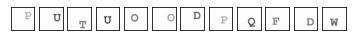

In [ ]:
trainer.model.eval()
res = []
dl_test = DataLoader(test_ds, shuffle=False, pin_memory=True, batch_size=12)
for b in dl_test:
    break
    # get_test_paths
logits = trainer.model(b["image"].to('cuda'))
    
    # logits = trainer.model(b["image"])
lts = []
for i in torch.argmax(logits, dim = 1):
    lts.append(to_letter(i))
    # res.extend(list(zip(lts, b["paths"])))
print("  ","   ".join(lts))
show([b["image"][i,:,:,:] for i in range(b["image"].shape[0])])

In [ ]:
trainer.model.eval()
res = []
dl_test = DataLoader(test_ds, shuffle=False, pin_memory=True, batch_size=128)
for b in dl_test:
    
    # get_test_paths
    logits = trainer.model(b["image"].to('cuda'))
    
    # logits = trainer.model(b["image"])
    lts = []
    for i in torch.argmax(logits, dim = 1):
        lts.append(to_letter(i))
    res.extend(list(zip(lts, b["paths"])))
    # print("  ","   ".join(lts))
    # show([b["image"][i,:,:,:] for i in range(b["image"].shape[0])])

In [ ]:
res_df = pd.DataFrame(res, columns = ["label", "path"])
# res_df["label"].value_counts()

W    1088
O    1069
L    1051
F     969
D     892
G     789
V     714
Y     708
A     661
U     631
P     613
Q     597
J     485
T     414
R     385
X     361
I     351
K     336
C     330
H     310
S     175
M     147
N     140
Z     130
E      88
B      22
Name: label, dtype: int64

In [ ]:
res_df.to_csv("resss.csv", index = False)

In [ ]:
f_name = "data"
if not os.path.exists(f_name):
    os.mkdir(f_name)

for i in tqdm(res_df["label"].unique()):
    if not os.path.exists(os.path.join(f_name, i)):
        os.mkdir(os.path.join(f_name, i))
    for path in res_df[res_df["label"] == i]["path"]:
        shutil.copyfile(os.path.join("imgs_r", "imgs_rotated", path), os.path.join(f_name, i, path))

  0%|          | 0/26 [00:00<?, ?it/s]

In [ ]:
!zip -r data.zip data